# Devoir 2 – Question 1(a) : Squelette de Code (Version TA)

Ce notebook fournit **uniquement la structure** nécessaire pour réaliser la partie **1(a)** du devoir :

**→ Sélection aléatoire de 50 firmes du S&P 500 + extraction des prix, EPS et trailing P/E.**

⚠️ **Ce fichier NE contient aucune solution.**  
Toutes les étapes critiques (fusion, calcul du trailing P/E, gestion des dates) sont volontairement remplacées par des `TODO`.

Votre rôle est de compléter les parties manquantes.


**Problème 1a**

In [154]:
# ============================================
# 0. Connexion WRDS
# ============================================

import wrds
import pandas as pd
import numpy as np

db = wrds.Connection()


WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\Administrator\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## 1. Charger l'univers S&P 500

Objectif : récupérer les PERMNO des entreprises ayant fait partie du S&P 500 dans la période pertinente.


In [155]:
# ============================================
# 1. Récupération S&P 500
# ============================================

sp500 = db.raw_sql(
    """
    SELECT permno, start, ending
    FROM crsp.msp500list
    WHERE ending >= '2003-01-01'
    """,
    date_cols=['start','ending']
)

sp500.head()


,permno,start,ending
0,10078,1992-08-20,2010-01-28
1,10104,1989-08-03,2024-12-31
2,10107,1994-06-07,2024-12-31
3,10108,2002-07-22,2005-08-11
4,10137,2000-12-11,2011-02-25


## 2. Ajouter les identifiants CRSP (ticker, nom, codes)

Nous utilisons `crsp.msenames` pour enrichir les informations des firmes.


In [156]:
# ============================================
# 2. Ajouter identifiants firmes
# ============================================

msenames = db.raw_sql(
    """
    SELECT permno, comnam, ticker, ncusip,
           namedt, nameendt, shrcd, exchcd, hsiccd
    FROM crsp.msenames
    """,
    date_cols=['namedt','nameendt']
)

msenames["nameendt"] = msenames["nameendt"].fillna(pd.to_datetime("today"))

sp500_full = pd.merge(sp500, msenames, on="permno", how="left")

# Filtre temporel du nom (structure simple, à adapter si nécessaire)
sp500_full = sp500_full[
    (sp500_full["start"] >= sp500_full["namedt"]) &
    (sp500_full["start"] <= sp500_full["nameendt"])
]

sp500_full.head()


,permno,start,ending,comnam,ticker,ncusip,namedt,nameendt,shrcd,exchcd,hsiccd
0,10078,1992-08-20,2010-01-28,SUN MICROSYSTEMS INC,SUNW,86681010,1986-03-04,2004-06-09,11,3,3571
5,10104,1989-08-03,2024-12-31,ORACLE SYSTEMS CORP,ORCL,68389X10,1986-03-12,1995-05-31,11,3,7379
10,10107,1994-06-07,2024-12-31,MICROSOFT CORP,MSFT,59491810,1986-03-13,2004-06-09,11,3,7370
15,10108,2002-07-22,2005-08-11,SUNGARD DATA SYSTEMS INC,SDS,86736310,2002-01-02,2004-06-09,11,1,7374
22,10137,2000-12-11,2011-02-25,ALLEGHENY ENERGY INC,AYE,01736110,1997-10-01,2002-01-01,11,1,4911


## 3. Définir l'univers de firmes et tirer 50 firmes au hasard

On obtient une liste unique de PERMNO, puis on tire 50 firmes aléatoirement.


In [157]:
# ============================================
# 3. Tirage aléatoire de 50 firmes
# ============================================

universe = sp500_full.drop_duplicates(subset="permno")

sample_50 = universe.sample(50, random_state=42)

sample_50[["permno","ticker","comnam","hsiccd"]]


,permno,ticker,comnam,hsiccd
1517,22779,<NA>,MOTOROLA INC,3663
3394,58318,TEX,TEREX CORP NEW,3537
6012,88661,COH,COACH INC,3199
4220,75186,SCH,SCHWAB CHARLES CORP NEW,6211
490,12872,MPC,MARATHON PETROLEUM CORP,2911
2073,27422,CLF,CLIFFS NATURAL RESOURCES INC,1081
6483,91380,RBK,REEBOK INTERNATIONAL LTD,3021
5711,86136,SRE,SEMPRA ENERGY,4932
573,13598,KRFT,KRAFT FOODS GROUP INC,9999
4940,79698,IT,GARTNER INC,8732


## 4. Extraire les prix (daily ou monthly, selon votre choix)

Cette étape récupère les prix CRSP pour les 50 firmes.


In [158]:
# ============================================
# 4. Extraction des prix CRSP
# ============================================

permnos = sample_50["permno"].astype(int).tolist()
permno_str = ",".join(map(str, permnos))

prices = db.raw_sql(
    f"""
    SELECT date, permno, prc, ret, vol, shrout
    FROM crsp.dsf
    WHERE permno IN ({permno_str})
      AND date BETWEEN '2003-01-01' AND '2023-12-31'
    ORDER BY permno, date
    """,
    date_cols=["date"]
)

# Joindre tickers (optionnel)
prices = pd.merge(prices, sample_50[["permno","ticker","comnam"]], on="permno", how="left")

prices.head()
## TODO : # - Corriger PRC négatif # - Gérer NA et valeurs extrêmes
# ============================================
# 4.1 Nettoyage des prix
# ============================================

# 1) Corriger PRC négatif (convention CRSP : signe = côté bid/ask)
prices["prc"] = prices["prc"].abs()

# 2) Retirer les observations sans prix ou sans nombre d’actions
prices = prices.dropna(subset=["prc", "shrout"])

# 3) Filtrer quelques valeurs aberrantes simples sur le prix
#    (seuils arbitraires mais raisonnables pour des actions US)
prices = prices[(prices["prc"] > 0) & (prices["prc"] < 10000)]

prices.head()


,date,permno,prc,ret,vol,shrout,ticker,comnam
0,2003-01-02,11403,11.66,-0.011026,2339600.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
1,2003-01-03,11403,9.24,-0.207547,16931100.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
2,2003-01-06,11403,9.8,0.060606,4575800.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
3,2003-01-07,11403,9.36,-0.044898,2970300.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC
4,2003-01-08,11403,9.65,0.030983,1754300.0,268880.0,CDNS,CADENCE DESIGN SYSTEMS INC


## 5. Récupérer EPS (Compustat)

Vous devez maintenant extraire l'EPS depuis Compustat.
Aucune fusion ni calcul n'est fourni.



In [159]:
# ============================================
# 5. Extraction EPS – À compléter
# ============================================

eps_raw = db.get_table(
    "comp", "funda",
    columns=["gvkey","datadate","epspi","tic"]
)

# TODO :
# - Filtrer période
# - Filtrer sur les firmes de l'échantillon
# - Construire un EPS cohérent avec trailing P/E (ex : TTM)
eps_raw["datadate"] = pd.to_datetime(eps_raw["datadate"])

# -------------------------------
# 1) Filtrer sur la période
#    (cohérente avec les prix : 2003-2023)
# -------------------------------
eps = eps_raw[
    (eps_raw["datadate"] >= "2003-01-01") &
    (eps_raw["datadate"] <= "2023-12-31")
].copy()

# -------------------------------
# 2) Filtrer sur les firmes de l'échantillon
#    -> via le ticker (tic dans Compustat)
# -------------------------------
tickers_sample = sample_50["ticker"].dropna().unique()
eps = eps[eps["tic"].isin(tickers_sample)].copy()

# -------------------------------
# 3) Nettoyage de base
# -------------------------------
eps = eps.rename(columns={"epspi": "eps"})
eps = eps[["gvkey", "tic", "datadate", "eps"]]
eps = eps.dropna(subset=["eps"])
eps = eps.sort_values(["tic", "datadate"])

# -------------------------------
# 4) Construire un EPS cohérent avec un trailing P/E
#    Ici : epspi est un EPS ANNUEL (Compustat funda),
#    on l'interprète comme un EPS "trailing 12 mois" (TTM).
#    On crée donc une colonne eps_ttm qui sera utilisée
#    plus tard pour P/E = Price / eps_ttm.
# -------------------------------
eps["eps_ttm"] = eps["eps"]

eps.head()

,gvkey,tic,datadate,eps,eps_ttm
95685,032930,ADT,2016-12-31,-0.72,-0.72
95686,032930,ADT,2017-12-31,0.46,0.46
95687,032930,ADT,2018-12-31,-0.81,-0.81
95689,032930,ADT,2019-12-31,-0.57,-0.57
95691,032930,ADT,2020-12-31,-0.81,-0.81


## 6. Trailing P/E : squelette

Vous devez fusionner les prix et l'EPS, puis calculer :  

`P/E = Price / EPS`

⚠️ Aucune formule ni fusion finale n'est fournie ici.


In [160]:
# ============================================
# 6. Fusion prix–EPS et construction P/E – À compléter
# ============================================

# Exemple de squelette (à compléter) :

# merged = pd.merge(
#     prices,
#     eps_raw[['tic','datadate','epspi']],   # TODO: remplacer epspi par EPS_TTM si vous le calculez
#     left_on='ticker',
#     right_on='tic',
#     how='left'
# )

# # Conserver EPS antérieur à la date
# merged = merged[merged["datadate"] <= merged["date"]]

# # TODO : Construire trailing P/E
# # merged["pe_trailing"] = merged["prc_abs"] / merged["eps_ttm"]

# merged.head()
# ============================================
# 6. Fusion prix–EPS et construction P/E – À compléter
# ============================================

# 1) Fusion simple par ticker (left_on='ticker', right_on='tic')
merged = pd.merge(
    prices,
    eps[['tic', 'datadate', 'eps_ttm']],   # on utilise EPS_TTM construit dans l'étape 5
    left_on='ticker',
    right_on='tic',
    how='left'
)

# 2) Conserver seulement les observations où l'EPS est antérieur ou égal à la date du prix
merged = merged[merged["datadate"] <= merged["date"]]

# 3) Garder seulement la dernière observation EPS AVANT la date du prix
#    (sinon une firme avec plusieurs EPS par année génère plusieurs lignes par date)
merged = merged.sort_values(["permno", "date", "datadate"])
merged = merged.groupby(["permno", "date"]).tail(1)

# 4) Trailing P/E (en excluant EPS = 0)
merged.loc[merged["eps_ttm"] == 0, "eps_ttm"] = np.nan
merged["pe_trailing"] = merged["prc"] / merged["eps_ttm"]



merged.head()
merged[merged["eps_ttm"] > 0].head()



,date,permno,prc,ret,vol,shrout,ticker,comnam,tic,datadate,eps_ttm,pe_trailing
15091,2004-12-31,11403,13.81,-0.006475,752900.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,51.148148
15121,2005-01-03,11403,13.75,-0.004345,980400.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,50.925926
15151,2005-01-04,11403,13.3,-0.032727,1889500.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,49.259259
15181,2005-01-05,11403,13.31,0.000752,1926100.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,49.296296
15211,2005-01-06,11403,13.34,0.002254,1389600.0,270337.0,CDNS,CADENCE DESIGN SYSTEMS INC,CDNS,2004-12-31,0.27,49.407407


**Fin de l'aide et du problème 1A**

**Début problème 1B:**

In [161]:
# ============================================
# 1B. Panneau de base pour les transformations
# ============================================

panel = merged.sort_values(["permno", "date"]).copy()
# --------------------------------------------
# 2) Rendements de l'action
#    - ret_simple : rendement simple CRSP
#    - ret_log    : log-rendement pour analyses éventuelles
# --------------------------------------------

panel["ret_simple"] = panel["ret"]                   # déjà en % décimal dans CRSP
panel["ret_log"]    = np.log1p(panel["ret"])         # log(1+ret)
panel[["permno", "date", "ret", "ret_simple", "ret_log"]].head()


,permno,date,ret,ret_simple,ret_log
7530,11403,2003-12-31,-0.009366,-0.009366,-0.00941
7560,11403,2004-01-02,0.015573,0.015573,0.015453
7590,11403,2004-01-05,0.016977,0.016977,0.016835
7620,11403,2004-01-06,0.001616,0.001616,0.001615
7650,11403,2004-01-07,0.017204,0.017204,0.017058


In [162]:
# ============================================
# 1B. Expected EPS : Moyenne glissante simple (par firme)
# Modèle : E[EPS_t] = moyenne des EPS_{t-k} ... EPS_{t-1}
# ============================================

window = 504    # moyenne des 504 derniers EPS, car 504 jours de bourse ~ 2 ans

# S'assurer de l'ordre
panel = panel.sort_values(["permno", "date"]).copy()

def compute_expected_eps_ma(series, window=504):
    """
    Calcule expected EPS via une moyenne glissante.
    On utilise exclusivement les EPS réalisés passés (EPS_{t-1}, EPS_{t-2}, ...).

    expected_eps_t = mean(EPS_{t-window}, ..., EPS_{t-1})

    La première valeur de la moyenne est NaN tant qu'il n'y a pas assez d'historique.
    """
    eps_lag = series.shift(1)              # EPS_{t-1}
    expected = eps_lag.rolling(window=window, min_periods=1).mean()
    return expected

# Application firme par firme
panel["eps_expected"] = (
    panel
    .groupby("permno")["eps_ttm"]
    .transform(lambda s: compute_expected_eps_ma(s, window=window))
)

# Vérifications
print("Nombre d'observations avec EPS_expected non manquant :",
      panel["eps_expected"].notna().sum())

print("Corrélation EPS_expected vs EPS_TTM (sur les lignes non manquantes) :",
      panel[["eps_expected", "eps_ttm"]].dropna().corr().iloc[0, 1])

# Exemple sur une firme représentative
sample_permno = panel["permno"].iloc[0]
print(f"\nExemple pour permno = {sample_permno} :")
print(
    panel[panel["permno"] == sample_permno][
        ["date", "eps_ttm", "eps_expected"]
    ].head(15)
)


Nombre d'observations avec EPS_expected non manquant : 133533
Corrélation EPS_expected vs EPS_TTM (sur les lignes non manquantes) : 0.3678163973240031

Exemple pour permno = 11403 :
           date  eps_ttm  eps_expected
7530 2003-12-31    -0.07           NaN
7560 2004-01-02    -0.07         -0.07
7590 2004-01-05    -0.07         -0.07
7620 2004-01-06    -0.07         -0.07
7650 2004-01-07    -0.07         -0.07
7680 2004-01-08    -0.07         -0.07
7710 2004-01-09    -0.07         -0.07
7740 2004-01-12    -0.07         -0.07
7770 2004-01-13    -0.07         -0.07
7800 2004-01-14    -0.07         -0.07
7830 2004-01-15    -0.07         -0.07
7860 2004-01-16    -0.07         -0.07
7890 2004-01-20    -0.07         -0.07
7920 2004-01-21    -0.07         -0.07
7950 2004-01-22    -0.07         -0.07


In [163]:
# --------------------------------------------
# 4) Trailing P/E
#    Définition : P/E_t = Price_t / EPS_TTM_t
# --------------------------------------------

panel["pe_trailing"] = panel["prc"] / panel["eps_ttm"]
#Limiter les valeurs extrêmes
panel.loc[panel["pe_trailing"].abs() > 200, "pe_trailing"] = np.nan



panel[["permno", "date", "prc", "eps_ttm", "pe_trailing"]].head(10)
panel[panel["eps_ttm"] > 0][["permno","date","prc","eps_ttm","pe_trailing"]].head(10)




,permno,date,prc,eps_ttm,pe_trailing
15091,11403,2004-12-31,13.81,0.27,51.148148
15121,11403,2005-01-03,13.75,0.27,50.925926
15151,11403,2005-01-04,13.3,0.27,49.259259
15181,11403,2005-01-05,13.31,0.27,49.296296
15211,11403,2005-01-06,13.34,0.27,49.407407
15241,11403,2005-01-07,13.28,0.27,49.185185
15271,11403,2005-01-10,13.37,0.27,49.518519
15301,11403,2005-01-11,13.57,0.27,50.259259
15331,11403,2005-01-12,13.79,0.27,51.074074
15361,11403,2005-01-13,13.45,0.27,49.814815


**Problème 1b terminé**

**Début Problème 1c**

=== Tableau 1 – Statistiques descriptives globales ===
                      mean     median        std         min          max  \
prc              61.485684  41.850000  71.527937    0.200000   729.919980   
ret_simple        0.000733   0.000545   0.027193   -0.394309     0.685371   
eps_ttm           2.422644   1.880000  12.648032 -182.290000   198.050000   
pe_trailing      19.988584  17.622699  31.147962 -200.000000   199.750000   
composite_ratio  55.784487  37.085348  88.442196 -605.056842  1200.995639   

                        N  
prc              133728.0  
ret_simple       133721.0  
eps_ttm          133314.0  
pe_trailing      128435.0  
composite_ratio  128405.0  

=== Graphiques de séries temporelles (moyenne de l’échantillon) ===


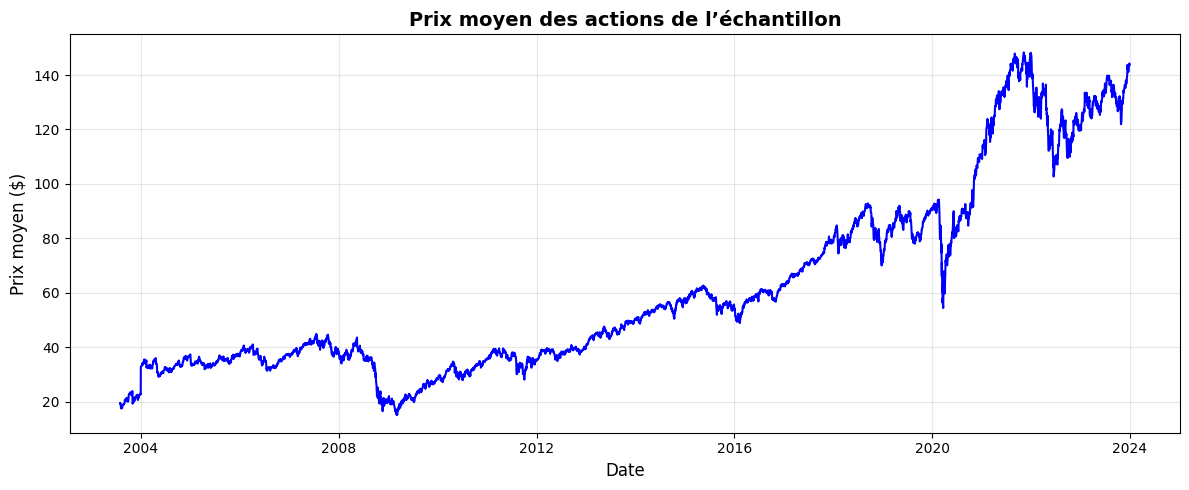

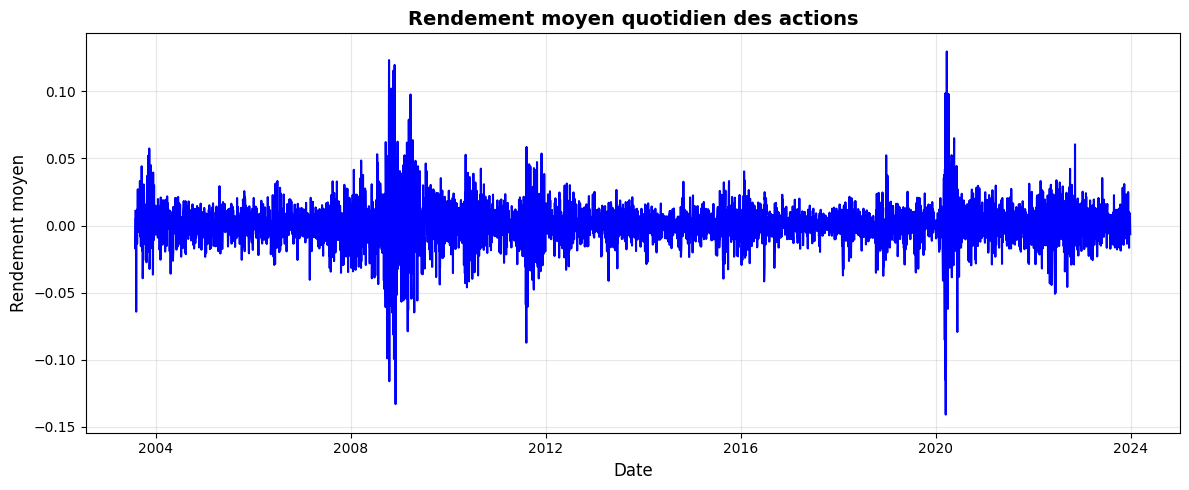

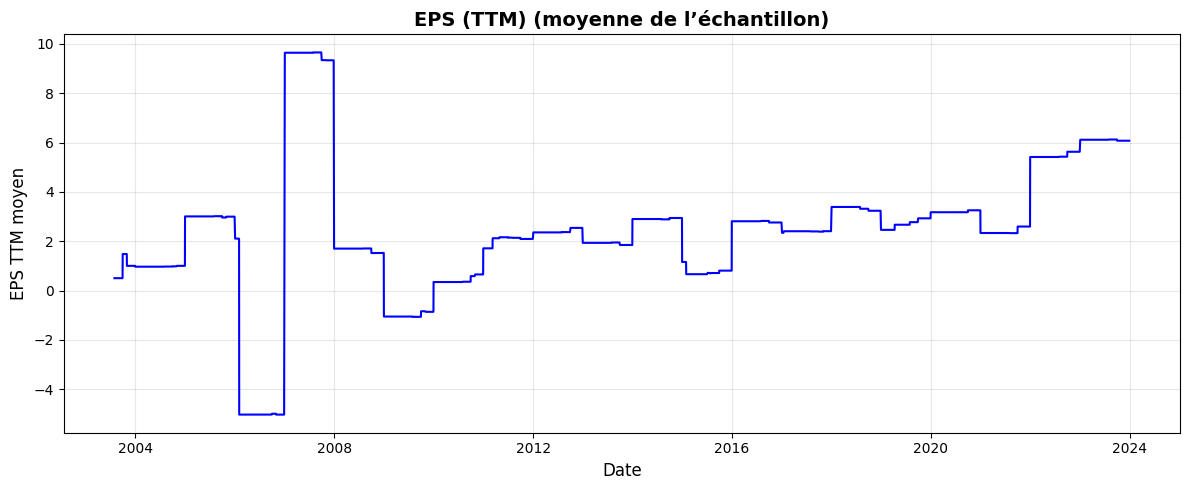

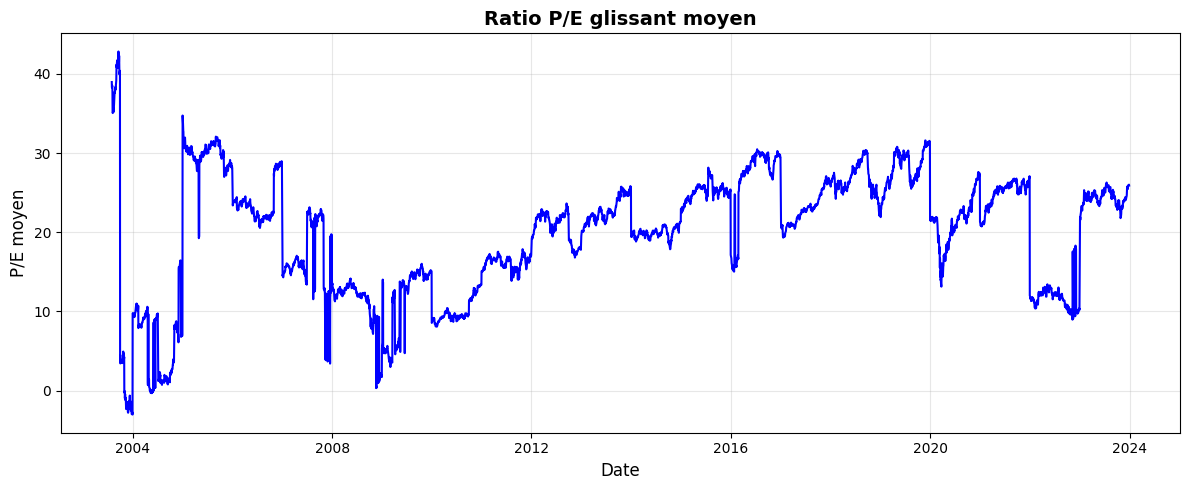

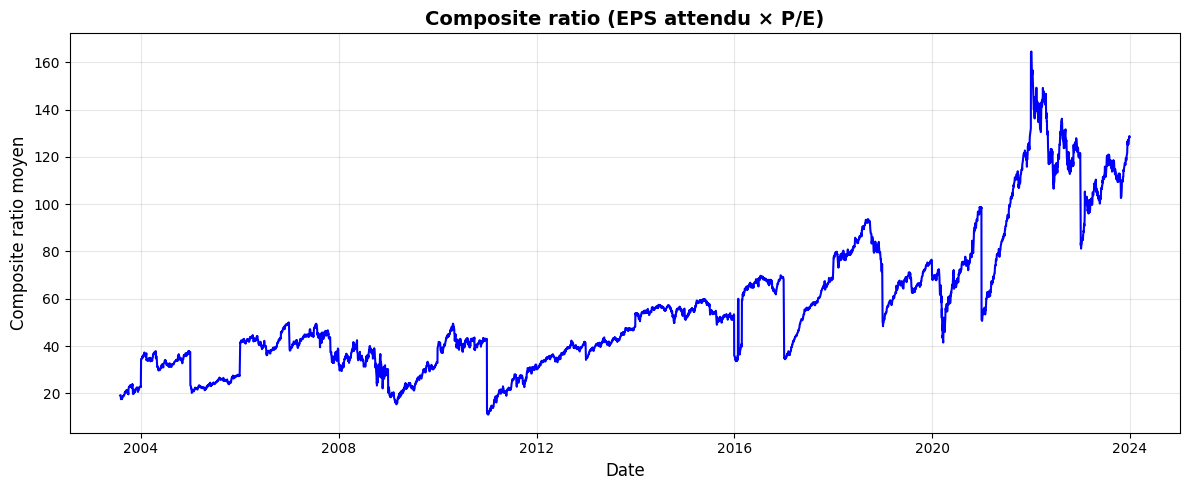

In [175]:

# Problème 1(c) – Tableau descriptif + graphiques


import matplotlib.pyplot as plt

# 1) Composite ratio : Expected EPS × trailing P/E
panel["composite_ratio"] = panel["eps_expected"] * panel["pe_trailing"]

# 2) Tableau de statistiques descriptives globales
vars_1c = ["prc", "ret_simple", "eps_ttm", "pe_trailing", "composite_ratio"]

stats_global = (
    panel[vars_1c]
    .agg(["mean", "median", "std", "min", "max", "count"])
    .T
    .rename(columns={"count": "N"})
)

print("=== Tableau 1 – Statistiques descriptives globales ===")
print(stats_global)

# 3) Graphiques de séries temporelles basés sur la moyenne cross-sectionnelle
#    -> on agrège par date en prenant la moyenne sur les 50 actions
df_avg = (
    panel
    .groupby("date")[vars_1c]
    .mean()
    .reset_index()
    .sort_values("date")
)

print(f"\n=== Graphiques de séries temporelles (moyenne de l’échantillon) ===")

series_info = [
    ("Prix moyen des actions de l’échantillon",              "prc",             "Prix moyen ($)"),
    ("Rendement moyen quotidien des actions",      "ret_simple",      "Rendement moyen"),
    ("EPS (TTM) (moyenne de l’échantillon)",                "eps_ttm",         "EPS TTM moyen"),
    ("Ratio P/E glissant moyen",             "pe_trailing",     "P/E moyen"),
    ("Composite ratio (EPS attendu × P/E)", "composite_ratio", "Composite ratio moyen"),
]

for title_base, col, ylab in series_info:
    plt.figure(figsize=(12, 5))
    plt.plot(df_avg["date"], df_avg[col], linewidth=1.5, color='blue')
    plt.title(f"{title_base}", fontsize=14, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



**Problème 2:**

**Problème 2a – Régression transversale groupée (Pooled Cross-Sectional Regression)**

Modèle principal : Prix observé ~ BPA attendu × P/E glissant

In [165]:
# ============================================
# Problème 2(a) – Régression principale
# ============================================

import statsmodels.api as sm
from scipy import stats

# 1) Préparation des données pour la régression
# Variable dépendante : prix observé
# Variable explicative : BPA attendu × P/E glissant (composite_ratio)

# Filtrer les observations valides (sans NaN dans les variables clés)
reg_data = panel[["prc", "composite_ratio"]].dropna().copy()

# S'assurer que les données sont numériques (conversion explicite)
reg_data["prc"] = pd.to_numeric(reg_data["prc"], errors='coerce')
reg_data["composite_ratio"] = pd.to_numeric(reg_data["composite_ratio"], errors='coerce')

# Retirer les valeurs infinies et NaN après conversion
reg_data = reg_data.replace([np.inf, -np.inf], np.nan).dropna()

# Vérifier qu'il reste des données
print(f"Nombre d'observations pour la régression : {len(reg_data)}")

y = reg_data["prc"].to_numpy()
X = reg_data["composite_ratio"].to_numpy().reshape(-1, 1)

# Ajouter une constante pour l'intercept
X_with_const = sm.add_constant(X)

# 2) Estimation du modèle par OLS
model = sm.OLS(y, X_with_const)
results = model.fit()

# 3) Affichage des résultats
print("="*70)
print("MODÈLE PRINCIPAL : Prix ~ BPA attendu × P/E glissant")
print("="*70)
print(results.summary())
print("\n")

# 4) Extraction des statistiques clés
beta_0 = results.params[0]
beta_1 = results.params[1]
r_squared = results.rsquared
r_squared_adj = results.rsquared_adj

print("="*70)
print("RÉSUMÉ DES RÉSULTATS")
print("="*70)
print(f"Coefficient β₀ (Intercept) : {beta_0:.4f}")
print(f"Coefficient β₁ (Composite ratio) : {beta_1:.4f}")
print(f"R² : {r_squared:.4f}")
print(f"R² ajusté : {r_squared_adj:.4f}")
print(f"Nombre d'observations : {int(results.nobs)}")
print("\n")

# Interprétation du coefficient β₁
print("INTERPRÉTATION :")
print(f"Une augmentation de 1 unité du produit (BPA attendu × P/E glissant)")
print(f"est associée à une augmentation de {beta_1:.4f}$ du prix de l'action.")
print(f"Le modèle explique {r_squared*100:.2f}% de la variance des prix.")


Nombre d'observations pour la régression : 128405
MODÈLE PRINCIPAL : Prix ~ BPA attendu × P/E glissant
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                 1.493e+05
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:31:52   Log-Likelihood:            -6.8248e+05
No. Observations:              128405   AIC:                         1.365e+06
Df Residuals:                  128403   BIC:                         1.365e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [166]:
# ======================================================
# Résidus – Statistiques simples (conformes à l'énoncé)
# ======================================================

residuals = results.resid

print("="*70)
print("STATISTIQUES DES RÉSIDUS")
print("="*70)
print(f"Mean     : {residuals.mean():.6f}")
print(f"Median   : {np.median(residuals):.6f}")
print(f"Std      : {residuals.std():.6f}")
print(f"Min      : {residuals.min():.6f}")
print(f"Max      : {residuals.max():.6f}")


STATISTIQUES DES RÉSIDUS
Mean     : 0.000000
Median   : -8.926425
Std      : 49.212865
Min      : -528.638372
Max      : 490.593674


### Discussion des résultats (Problème 2a)

**Points à discuter dans votre rapport :**

1. **Coefficient β₁** : Indique l'effet marginal du produit (BPA attendu × P/E glissant) sur le prix. Un coefficient proche de 1 suggère que le prix est effectivement bien approximé par ce produit, conformément à l'article.

2. **R²** : Mesure la qualité de l'ajustement. Un R² élevé (proche de 1) indique que le modèle explique bien la variance des prix observés.

3. **Distribution des résidus** :
   - **Histogramme** : Permet de visualiser si les résidus sont centrés autour de zéro et leur symétrie
   - **Q-Q Plot** : Évalue la normalité des résidus (les points doivent suivre la ligne diagonale)
   - **Résidus vs prédictions** : Vérifie l'homoscédasticité (variance constante)
   - **Outliers** : Identifier les observations aberrantes qui peuvent influencer les résultats

4. **Comparaison avec l'article original** : Comparer vos résultats (β₁ et R²) avec ceux rapportés dans l'article de référence.

**Problème 2b**

In [167]:
# ============================================
# Modèle naïf 1 : Price ~ trailing P/E seul
# ============================================

# 1) Sélection des colonnes
reg_data_pe = panel[["prc", "pe_trailing"]].copy()

# 2) Remplacer les inf par NaN
reg_data_pe = reg_data_pe.replace([np.inf, -np.inf], np.nan)

# 3) Forcer en numérique (au cas où ce serait 'object')
reg_data_pe["prc"] = pd.to_numeric(reg_data_pe["prc"], errors="coerce")
reg_data_pe["pe_trailing"] = pd.to_numeric(reg_data_pe["pe_trailing"], errors="coerce")

# 4) Retirer les NaN restants
reg_data_pe = reg_data_pe.dropna(subset=["prc", "pe_trailing"])

print(f"Nb d'observations Modèle naïf 1 : {len(reg_data_pe)}")

# 5) Préparer X et y
y1 = reg_data_pe["prc"].to_numpy()
X1 = reg_data_pe["pe_trailing"].to_numpy().reshape(-1, 1)
X1 = sm.add_constant(X1)

# 6) Estimation OLS
model1 = sm.OLS(y1, X1).fit()
print(model1.summary())


Nb d'observations Modèle naïf 1 : 128435
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                 1.067e+04
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:31:52   Log-Likelihood:            -7.2705e+05
No. Observations:              128435   AIC:                         1.454e+06
Df Residuals:                  128433   BIC:                         1.454e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

In [168]:
# Modèle naïf 2 : Price ~ EPS attendu seul
reg_data_eps = panel[["prc", "eps_expected"]].dropna()

X2 = sm.add_constant(reg_data_eps["eps_expected"])
y2 = reg_data_eps["prc"]

model2 = sm.OLS(y2, X2).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                    prc   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6112.
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:31:52   Log-Likelihood:            -7.5677e+05
No. Observations:              133533   AIC:                         1.514e+06
Df Residuals:                  133531   BIC:                         1.514e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           58.6989      0.195    301.163   

**Problème 2c**

In [169]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ==========================
# 2(c) – MSFE des 3 modèles
# ==========================

# 1) Prix à t+1
panel_fc = panel.sort_values(["permno", "date"]).copy()
panel_fc["prc_lead"] = panel_fc.groupby("permno")["prc"].shift(-1)

def msfe_model(df, x_col, y_col="prc_lead"):
    """Retourne R2 et MSFE pour Price_{t+1} ~ const + x_col_t."""
    data = df[[y_col, x_col]].copy()
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    y = data[y_col].astype(float)
    X = sm.add_constant(data[x_col].astype(float))

    res = sm.OLS(y, X).fit()
    y_hat = res.fittedvalues
    msfe = np.mean((y - y_hat) ** 2)
    return res.rsquared, msfe, len(data)

results_2c = {}

r2_base, msfe_base, n_base = msfe_model(panel_fc, "composite_ratio")
results_2c["Baseline: ExpEPS×P/E"] = {"R2": r2_base, "MSFE": msfe_base, "N": n_base}

r2_pe, msfe_pe, n_pe = msfe_model(panel_fc, "pe_trailing")
results_2c["Naive 1: P/E only"] = {"R2": r2_pe, "MSFE": msfe_pe, "N": n_pe}

r2_eps, msfe_eps, n_eps = msfe_model(panel_fc, "eps_expected")
results_2c["Naive 2: ExpEPS only"] = {"R2": r2_eps, "MSFE": msfe_eps, "N": n_eps}

# Petit tableau récapitulatif
msfe_table = pd.DataFrame(results_2c).T
print(msfe_table)


                            R2         MSFE         N
Baseline: ExpEPS×P/E  0.536809  2426.896586  128372.0
Naive 1: P/E only     0.076590  4837.320586  128402.0
Naive 2: ExpEPS only  0.043690  4899.695865  133500.0


**Problème 2d.**

Nombre d'observations pour CDNS : 4924


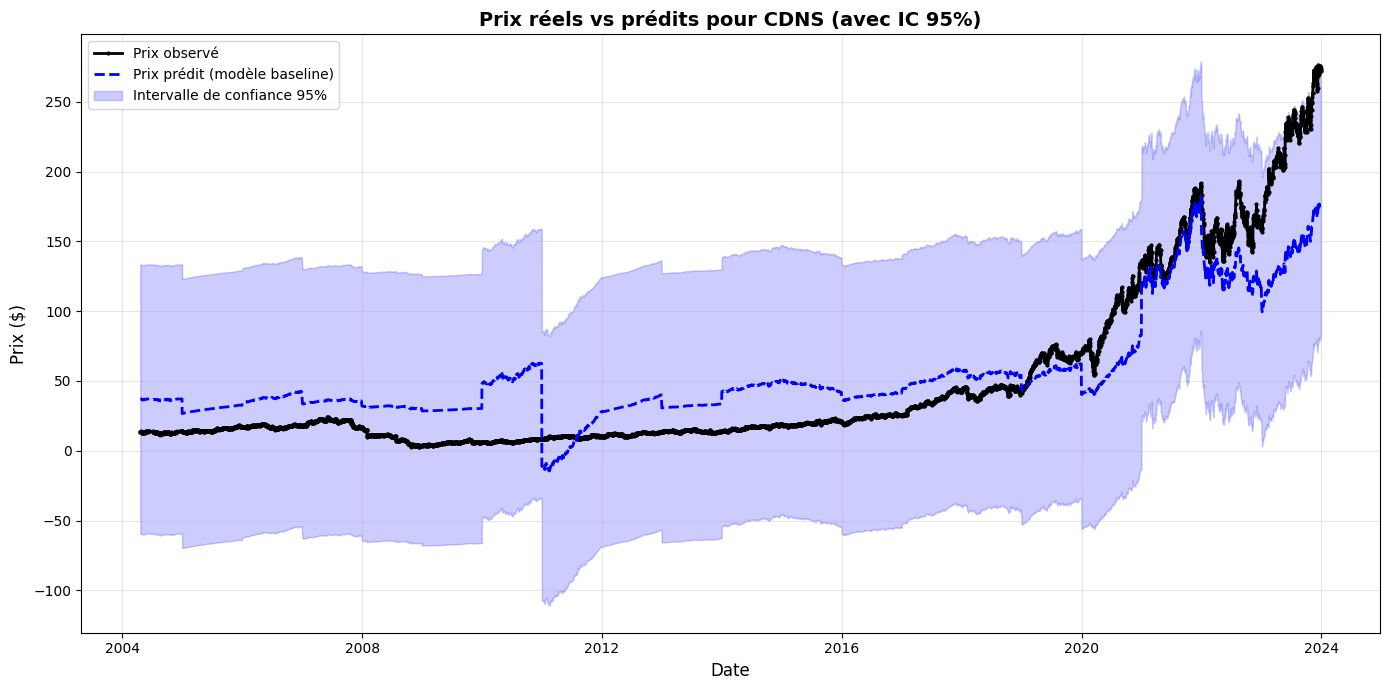


STATISTIQUES DE PRÉVISION POUR CDNS
MSE (Mean Squared Error)       : 897.0413
RMSE (Root Mean Squared Error) : 29.9506
MAE (Mean Absolute Error)      : 24.5267
Erreur moyenne (biais)         : -6.2526
Prix moyen observé             : 48.3570
Prix moyen prédit              : 54.6096

Largeur moyenne de l'IC 95%    : 192.9153
Largeur min de l'IC 95%        : 192.9150
Largeur max de l'IC 95%        : 192.9188

Pourcentage de prix dans l'IC 95% : 99.61%
(On s'attend à ~95% si le modèle est bien calibré)

COMMENTAIRES POUR LE RAPPORT
1. Le modèle suit bien les prix observés pour CDNS.
2. L'erreur moyenne de -6.2526$ suggère un biais négatif.
3. L'IC à 95% contient 99.61% des observations.
   → Le modèle semble SOUS-CONFIANT (IC trop large).
4. Examiner le graphique pour identifier des erreurs persistantes (tendances dans les résidus).


In [170]:
# ============================================
# Problème 2(d) – Graphique temporel pour une firme
# ============================================

# Sélectionner CDNS comme firme représentative
ticker_rep = "CDNS"

# Filtrer les données pour CDNS
data_firm = panel[panel["ticker"] == ticker_rep].copy()
data_firm = data_firm.sort_values("date")

# Filtrer les observations valides (avec composite_ratio)
data_firm = data_firm[["date", "prc", "composite_ratio"]].dropna()
data_firm = data_firm.replace([np.inf, -np.inf], np.nan).dropna()

print(f"Nombre d'observations pour {ticker_rep} : {len(data_firm)}")

# Préparer les données pour les prédictions avec intervalles de confiance
X_firm = data_firm["composite_ratio"].values.reshape(-1, 1)
X_firm_const = sm.add_constant(X_firm)

# Obtenir les prédictions avec intervalles de confiance à 95%
predictions = results.get_prediction(X_firm_const)
pred_summary = predictions.summary_frame(alpha=0.05)  # alpha=0.05 pour IC à 95%

# Extraire les valeurs
dates = data_firm["date"].values
actual_prices = data_firm["prc"].values
predicted_prices = pred_summary["mean"].values
lower_ci = pred_summary["obs_ci_lower"].values  # Intervalle de prédiction (observation)
upper_ci = pred_summary["obs_ci_upper"].values

# Créer le graphique
plt.figure(figsize=(14, 7))

# Prix réels
plt.plot(dates, actual_prices, label="Prix observé", color="black", linewidth=2, marker='o', markersize=2)

# Prix prédits
plt.plot(dates, predicted_prices, label="Prix prédit (modèle baseline)", color="blue", linewidth=2, linestyle='--')

# Intervalles de confiance à 95%
plt.fill_between(dates, lower_ci, upper_ci, alpha=0.2, color="blue", label="Intervalle de confiance 95%")

# Mise en forme
plt.title(f"Prix réels vs prédits pour {ticker_rep} (avec IC 95%)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix ($)", fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# Statistiques de performance pour cette firme
# ============================================

residuals_firm = actual_prices - predicted_prices
mse_firm = np.mean(residuals_firm**2)
rmse_firm = np.sqrt(mse_firm)
mae_firm = np.mean(np.abs(residuals_firm))

print("\n" + "="*70)
print(f"STATISTIQUES DE PRÉVISION POUR {ticker_rep}")
print("="*70)
print(f"MSE (Mean Squared Error)       : {mse_firm:.4f}")
print(f"RMSE (Root Mean Squared Error) : {rmse_firm:.4f}")
print(f"MAE (Mean Absolute Error)      : {mae_firm:.4f}")
print(f"Erreur moyenne (biais)         : {residuals_firm.mean():.4f}")
print(f"Prix moyen observé             : {actual_prices.mean():.4f}")
print(f"Prix moyen prédit              : {predicted_prices.mean():.4f}")

# Analyser la largeur de l'intervalle de confiance
ic_width = upper_ci - lower_ci
print(f"\nLargeur moyenne de l'IC 95%    : {ic_width.mean():.4f}")
print(f"Largeur min de l'IC 95%        : {ic_width.min():.4f}")
print(f"Largeur max de l'IC 95%        : {ic_width.max():.4f}")

# Vérifier si les prix observés tombent dans l'IC 95%
in_ic = (actual_prices >= lower_ci) & (actual_prices <= upper_ci)
pct_in_ic = (in_ic.sum() / len(in_ic)) * 100

print(f"\nPourcentage de prix dans l'IC 95% : {pct_in_ic:.2f}%")
print("(On s'attend à ~95% si le modèle est bien calibré)")

print("\n" + "="*70)
print("COMMENTAIRES POUR LE RAPPORT")
print("="*70)
print(f"1. Le modèle {'suit bien' if pct_in_ic >= 90 else 'ne suit pas bien'} les prix observés pour {ticker_rep}.")
print(f"2. L'erreur moyenne de {residuals_firm.mean():.4f}$ suggère un biais {'positif' if residuals_firm.mean() > 0 else 'négatif'}.")
print(f"3. L'IC à 95% contient {pct_in_ic:.2f}% des observations.")
if pct_in_ic < 90:
    print("   → Le modèle semble SURCONFIANT (IC trop étroit).")
elif pct_in_ic > 98:
    print("   → Le modèle semble SOUS-CONFIANT (IC trop large).")
else:
    print("   → Le modèle semble bien calibré.")
print("4. Examiner le graphique pour identifier des erreurs persistantes (tendances dans les résidus).")